In [1]:
# For operating system interaction
import os
import glob
import datetime
import sys

# For loading .pkl files.
import pickle

# For scientific computing
import numpy as np
import pandas as pd
import scipy.special
import statsmodels.tools.numdiff as smnd # to compute the Hessian matrix

# To compute symbolic expressions
import sympy

# Import custom utilities
import mwc_induction_utils as mwc

# Useful plotting libraries
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
mwc.set_plotting_style()

# Magic function to make matplotlib inline; other style specs must come AFTER
%matplotlib inline

# This enables SVG graphics inline
%config InlineBackend.figure_format = 'svg'

# Define function to compute fugacity

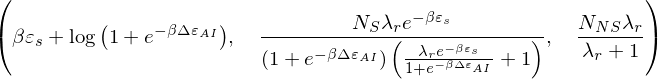

In [21]:
# print outputs in LaTeX
sympy.init_printing(use_unicode=True)

# Define symbolic variables for sympy
R, Ns, lam, es, Nns = \
sympy.symbols('R N_S \\lambda_r \\beta\\varepsilon_s N_{{NS}}')
eAI = sympy.symbols('\\beta\\Delta\\varepsilon_{{AI}}')

# Define equation for Rtot with average occupancies
energy = es + sympy.log(1 + sympy.exp(-eAI))
Rs = Ns * lam * sympy.exp(-energy) / (1 + lam * sympy.exp(-energy))
Rns = Nns * lam / (1 + lam)
energy, Rs, Rns

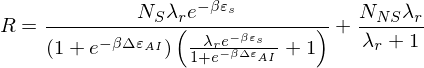

In [22]:
# Compute equation for total number of repressors and average occupancy
Rtot = sympy.Eq(R, Rs + Rns)
Rtot

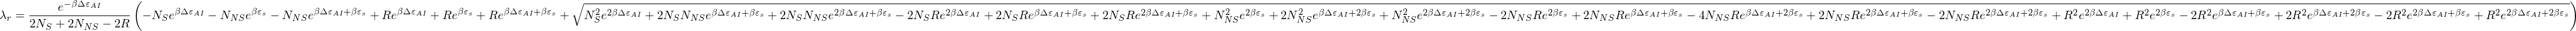

In [25]:
# Solve equation for lambda.
# Keep second entry since is the strictly positive root
lam_sol = sympy.solve(Rtot, lam)[1]
sympy.Eq(lam, lam_sol)

## Generate `lambdify` funciton to evaluate root numerically

In [28]:
# Define lambdify function
lam_num = sympy.lambdify([R, es, eAI, Ns, Nns], lam_sol, 'numpy')

# Turn off fancy Latex printing
sympy.init_printing(pretty_print=False) # print outputs in LaTeX

## Define fold-change function

In [29]:
def fold_change(R, es, eAI, Ns, Nns=4.6E6):
    '''
    Computes the fold-change in gene expression for multiple simple repression
    promoters using the Grand canonical formulation in the absence of inducer.
    Parameters
    ----------
    R : array-like.
        Total number of repressors per cell.
    es : array-like.
        Binding energy of the repressor to the operator as determined by
        Garcia and Phillips for single promoter constructs.
    eAI : array-like.
        Energy difference between active and inactive states of the repressor.
    Ns : array-like.
        Number of promoters per cell.
    Nns : float.
        Number of non-specific binding sites
    
    Returns
    -------
    Theoretical fold-change
    '''
    
    # Solve for the fugacity lambda_r given the parameters
    fugacity = lam_num(R, es, eAI, Ns, Nns)
    
    # Obtain the adjusted energy
    energy = es + np.log(1 + np.exp(-eAI))
    # Compute the theoretical fold change
    return 1 / (1 + fugacity * np.exp(-energy))

Testing the function

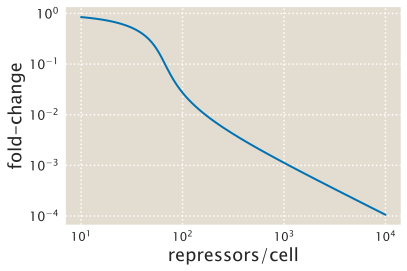

In [31]:
R_array = np.logspace(1, 4, 100) # repressors per cell
es = -15.3 # kBT
eAI = 4.5 # kBT
Ns = 64 # mean plasmid copy number

# Compute theoretical fold-change
fc_theory = fold_change(R_array, es, eAI, Ns)

# Plot theoretical prediciton on log-log
plt.loglog(R_array, fc_theory)

# Label axis
plt.xlabel('repressors/cell')
plt.ylabel('fold-change')

# Read Brewster et al. data

In [32]:
df = pd.read_csv('../../data/tidy_Brewster_etal_Cell_2014.csv')
df.head()

,operator,energy,repressors,fold_change,delta_repressors,delta_fold_change,Ns,Nc
0,O1,-15.3,3.570,1.0460,6.464,1.1430,64,0
1,O1,-15.3,4.751,0.9676,7.651,1.0630,64,0
2,O1,-15.3,5.478,1.0230,8.382,1.1570,64,0
3,O1,-15.3,6.545,1.1680,9.457,1.4150,64,0
4,O1,-15.3,7.211,0.8455,10.130,0.9419,64,0


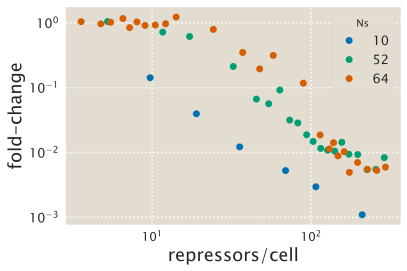

In [35]:
# Group by number of promoteres per cell
df_group = df.groupby('Ns')

# Plot raw data for all independent data sets
for group, data in df_group:
    plt.loglog(data.repressors, data.fold_change, linewidth=0, marker='o',
               label=str(group))
    
# Label axis
plt.xlabel('repressors/cell')
plt.ylabel('fold-change')
plt.legend(title=r'Ns')

### Compare our current value for $\Delta\varepsilon_{AI}=4.5\;k_BT$ 

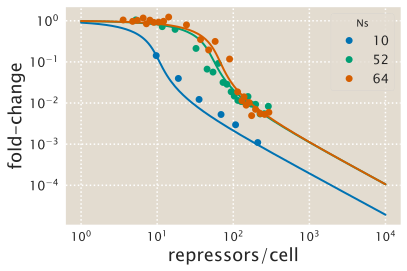

In [38]:
R_array = np.logspace(0, 4, 150) # repressors per cell
eAI = 4.5 # kBT

# Plot raw data
df_group = df.groupby('Ns')

colors = sns.color_palette('colorblind', n_colors=3)
i = 0 # initialize counter
# Plot raw data for all independent data sets
for group, data in df_group:
    # Compute theoretical fold change
    es = data.energy.unique()[0]
    Ns = group
    fc_theory = fold_change(R_array, es, eAI, Ns)
    
    # Plot theoretical prediction for 4.5 kBT
    plt.loglog(R_array, fc_theory, label='', color=colors[i])
    plt.loglog(data.repressors, data.fold_change, linewidth=0, marker='o',
               label=str(group), color=colors[i])
    i += 1
    
# Label axis
plt.xlabel('repressors/cell')
plt.ylabel('fold-change')
plt.legend(title=r'Ns')

# Code the marginalized posterior $P(\Delta\varepsilon_{AI}\mid D)$

In [39]:
def log_post(fc_exp, R, es, eAI, Ns, Nns=4.6E6):
    '''
    Compute the unnormalized student-t distribution given some experimental 
    fold-changes for a multiple promoter architecture.
    
    Parameters
    ----------
    fc_exp : array-like.
        Experimental gene-expression fold-change
    R : array-like.
        Total number of repressors per cell.
    es : array-like.
        Binding energy of the repressor to the operator as determined by
        Garcia and Phillips for single promoter constructs.
    eAI : array-like.
        Energy difference between active and inactive states of the repressor.
    Ns : array-like.
        Number of promoters per cell.
    Nns : float.
        Number of non-specific binding sites
    
    Returns
    -------
    Unormalized log posterior.
    '''
    # Compute the theoretical fold-change
    fc_theory = fold_change(R, es, eAI, Ns, Nns)
    
    # compute the un-normalized log-posterior
    return - len(fc_exp) / 2 * np.sum((fc_exp - fc_theory)**2)

In [42]:
# Evaluate log_posterior in a grid of epsilon energies
eAI_array = np.linspace(-5, 20, 200) # kBT

# initialize log_posterior array
lnp = np.zeros_like(eAI_array)

# Evaluate log posterior in a for-loop
for i, eAI in enumerate(eAI_array):
    lnp[i] = log_post(df.fold_change, df.repressors, df.energy, eAI, df.Ns)

lnp -= np.max(lnp)

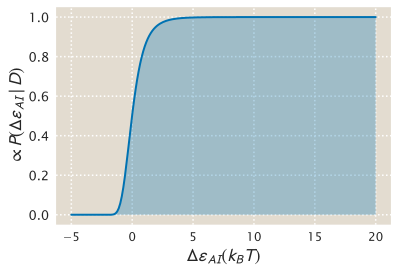

In [45]:
plt.plot(eAI_array, np.exp(lnp))
plt.xlabel(r'$\Delta\varepsilon_{AI} (k_BT)$')
plt.fill_between(eAI_array, np.exp(lnp), alpha=0.3)
plt.ylabel(r'$\propto P(\Delta\varepsilon_{AI} \mid D)$')

# Not assuming Hernan's energies

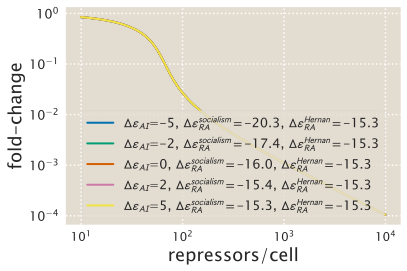

In [73]:
eAI_values = np.array([-5, -2, 0, 2, 5])
es_values = np.array([-15.3 -np.log(1 + np.exp(-eAI)) for eAI in eAI_values])

R_array = np.logspace(1, 4, 100) # repressors per cell
Ns = 64 # mean plasmid copy number

for i, eAI in enumerate(eAI_values):
    # Compute theoretical fold-change
    fc_theory = fold_change(R_array, es_values[i], eAI, Ns)

    # Plot theoretical prediciton on log-log
    plt.loglog(R_array, fc_theory, label=\
               r'$\Delta\varepsilon_{AI}$=' + str(eAI)+\
               r', $\Delta\varepsilon_{RA}^{socialism}=$' +\
               str(np.round(es_values[i], 1))+\
               r', $\Delta\varepsilon_{RA}^{Hernan}=$' + 
               str(es_values[i] + np.log(1 + np.exp(-eAI))))

plt.legend(loc='lower center')
# Label axis
# plt.xlim(left =1E-4, right=1E5)
plt.xlabel('repressors/cell')
plt.ylabel('fold-change')


In [58]:
es_values + np.log(1 + np.exp(-eAI_values))

array([-15.3, -15.3, -15.3, -15.3, -15.3])

In [42]:
# Evaluate log_posterior in a grid of energies
eAI_array = np.linspace(-5, 20, 200) # kBT
es_array = np.linspace(-10, -20, 200)

# Generate 2D meshgrid
eeAI, ees = np.meshgrid(eAI_array, es_array)


# initialize log_posterior array
lnp = np.zeros_like(eeAI)

# Evaluate log posterior in a for-loop
for i, eAI in enumerate(eAI_array):
    lnp[i] = log_post(df.fold_change, df.repressors, df.energy, eAI, df.Ns)

lnp -= np.max(lnp)